<h1 style="text-align: center;">Topic Evolution in Life Sciences Research</h1>

## Executive Summary
The aim of this project was to use the text from biomedical and life science literature to gain insights on research topic trends over time. The data was extracted from the [text mining collections](https://www.ncbi.nlm.nih.gov/pmc/tools/textmining/) made available by the [PubMed Central (PMC) archive](https://www.ncbi.nlm.nih.gov/pmc/about/intro/), an archive of biomedical and life sciences journal literature at the U.S. National Institutes of Health's National Library of Medicine. Through dynamic topic modeling, I discovered the underlying themes of the text collections and observed some interesting changes over time. This method offers new ways to automatically organize, search, index, and browse large document collections.

## Introduction
The explosion of electronic document archives has allowed us to explore such collections like never before; the sheer volumes of the documents has also presented immense challenges. I sought to use machine learning tools to discover the underlying themes in the biomedical and life science literature as well as their trends over time.

## Methods and Results
The data was obtained from a subset of the [PubMed Central (PMC) archive](https://www.ncbi.nlm.nih.gov/pmc/about/intro/), an archive of biomedical and life sciences journal literature at the U.S. National Institutes of Health's National Library of Medicine, which is made [freely available](https://www.ncbi.nlm.nih.gov/pmc/tools/textmining/) to the public under a Creative Commons or similar license. This subset contains over 1 millions articles. Specifically, for each article, meta data (such as publication year, journal title, etc.) and content (article title and abstract) were extracted from the corresponding XML file. Natural Language Processing technique was used to extract text features from the article titles and abstracts. The text was then analyzed by dynamic topic modeling, which captures the evolution of topics in a sequentially organized corpus of documents.  
  
As a proof of concept, I analyzed 23,896 articles from [_The Journal of Cell Biology_](http://jcb.rupress.org/) from 1962 through present (2017). The corpus is made up of approximately 2.2 million words. The vocabulary was pruned by "[lemmatizing](http://www.nltk.org/api/nltk.stem.html#nltk.stem.wordnet.WordNetLemmatizer)", removing stop words, and removing terms that occurred fewer than 20 times. The total vocabulary size is 6,619. To explore the themes in the collection, I estimated a 10-component dynamic topic model. A few  of the resulting topics are illustrated in detail [below](#Process-output).  
  
I also analyzed a collection from _The Journal of Experimental Medicine_, which is detailed [here](jem_9topics.ipynb).

## Interpretation of Results
The 10 resulting topics can be roughly summarized as:
0. cytoskeletal systems
1. inter-cell communications
2. nucleus, cell replications and cycles
3. inter- and intra-cell transport
4. neuroscience
5. cell signaling
6. imaging techniques (esp. microscopy)
7. gene transcription and translation
8. cell/tissue cultures, cancer research
9. mitochondria
  
This appears to be a comprehensive high-level list of topics in cell biology. 

A closer took at the key terms in some of these topics revealed some interesting (although maybe not so surprising) trends in research. For example, within the "nucleus and cell cycles" topic, the term "microtubule" peaked in the 1980s, "nucleus" has been on decline since 1970s, and new entities such "kinetochore" and "assembly" are on the rise. As another example, within the "cell/tissue cultures & cancer research" topic, 
"culture" has been on the decline since 1980s, while "stem" (presumably as in "stem cell") and "cancer" are on the rise since 1990s.

## Conclusion
Dynamic topic modeling technique has been shown to be a powerful tool for organizing and exploring a large collection of text documents. When applied to biomedical and life science literature, it can aid researchers and curious laypersons alike to discover interesting themes and trends.

## Recommendations / Next Steps
The analysis can be extended to the whole text mining collections from PMC; it can also be extended to the full text of the articles. In addition, the text extraction procedure can be further scrutinized for optimization (cleaner text, less missing information, etc.). In regard to domain-specific terms, efforts can be made to build up stop word collection, as well as to improve the stemming procedures, for the purpose of further pruning the vocabulary. Lastly, it would be interesting to compare the results from the dynamic topic models with those from other topic models such as `gensim`'s LDA module.

# Code
- [Data Extraction](#Data-Extraction)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Cleaning](#Data-Cleaning)
- [Modeling](#Modeling)

In [1]:
import os
import csv
import time
from lxml import etree, html

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer


# import the EDA functions I've built in a Python script
from eda import *

In [2]:
# set display options
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Data Extraction
#### Extract the meta data, title, and abstract of each article from the `.nxml` files and append to a `.csv` file
The downloaded files (a total of 122.7 GB after unzipping) are organized in a few layers of subdirectories; the "leaf nodes" are `.nxml` files, each of which corresponds to one journal article. All articles from the same journal are organized in the same subdirectory.

In [2]:
CSV = '/run/media/fay/Seagate Backup Plus Drive/GA capstone/comm_use.csv'
CWD = '/run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use'

# xpaths to meta data to be extracted
XPATHS = [
    '/article/front/article-meta/article-id[@pub-id-type="pmid"]',
    '/article/front/article-meta/article-id[@pub-id-type="pmc"]',
    '/article/front/article-meta/article-id[@pub-id-type="doi"]',
    '/article/front/article-meta/article-categories/subj-group/subject',
    '/article/front/article-meta/pub-date/year',
    '/article/front/article-meta/pub-date/month',
    '/article/front/article-meta/pub-date/day',
    '/article/front/journal-meta/publisher/publisher-name',
    '/article/front/journal-meta/journal-id',
    '//journal-title'
]

# article titles and abstracts often contain HTML tags
# so text needs to be extracted differently
XPATHS_HTML_EL = [
    '/front/article-meta/title-group/article-title',
    '/front/article-meta/abstract'
]

In [4]:
def find_xml_paths(cwd):
    xml_paths = [[os.path.join(os.path.abspath(dirpath), f) 
                  for f in filenames if f.endswith('.nxml')]
                 for dirpath, dirnames, filenames in os.walk(cwd)]
    # remove empty lists
    return [journal for journal in xml_paths if journal]

In [3]:
def xml_to_csv(xml_paths, csvfile):
    for journal in xml_paths:
        for xml_path in journal:
            entry = extract_elements(xml_path)
            append_to_csv(csvfile, entry)   
            
        # progress report
        print('Finished ' + os.path.dirname(journal[0]))

In [5]:
def extract_elements(xml_path):
    tree = etree.parse(xml_path)    
    entry = [xml_path]  # include xml_path for debugging purpose

    for path in XPATHS:
        try:
            entry.append(tree.xpath(path)[0].text)
        except IndexError:
            entry.append(None)

    for path in XPATHS_HTML_EL:
        entry.append(extract_text(tree, path))
    
    return entry

In [6]:
def extract_text(tree, xpath):
    el = tree.find(xpath)
    if el is not None:
        # convert the xml element to a html element
        html_el = html.fragment_fromstring(etree.tostring(el))
        return html_el.text_content().strip().replace('\xa0', ' ')
    else:
        return ''

In [3]:
def append_to_csv(csvfile, entry):
    with open(csvfile, 'a', newline='') as f:
        entry_writer = csv.writer(f, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        entry_writer.writerow(entry)

In [ ]:
header = ['file_path', 
          'pmid', 
          'pmc', 
          'doi', 
          'article_subject', 
          'pub_year', 
          'pub_month', 
          'pub_day', 
          'publisher_name', 
          'journal_id', 
          'journal_title',
          'article_title',
          'abstract'
         ]

append_to_csv(CSV, header)

In [8]:
%%time
xml_paths = find_xml_paths(CWD)

CPU times: user 9.22 s, sys: 696 ms, total: 9.91 s
Wall time: 53.4 s


[Skip the output of the next cell and jump to [EDA](#Exploratory-Data-Analysis)]

In [9]:
%%time
xml_to_csv(xml_paths, CSV)

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Ann_Neurol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/20_Century_Br_Hist
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/3_Biotech
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/AAPS_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/AAPS_PharmSciTech
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Abdom_Imaging
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Abdom_Radiol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Abdom_Radiol_(NY)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Acad_Emerg_Med
Fi

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Aerobiologia_(Bologna)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Aggress_Violent_Behav
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/AIMS_Genet
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Allergy
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Am_J_Clin_Nutr
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Am_J_Med_Genet_C_Semin_Med_Genet
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Am_J_Public_Health
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Anal_Chem_Insights
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/com

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Adv_Virol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Adv_Water_Resour
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Adv_Wound_Care_(New_Rochelle)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/AERA_Open
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Aerosol_Sci_Technol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Aesthetic_Plast_Surg
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Aesthet_Surg_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Africa_(Lond)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_us

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Am_J_Hum_Biol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Am_J_Hum_Genet
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Am_J_Hypertens
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Am_J_Ind_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Am_J_Kidney_Dis
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Am_J_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Am_J_Med_Genet_A
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Am_J_Med_Genet_B_Neuropsychiatr_Genet
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_us

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Ann_Behav_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Ann_Biomed_Eng
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Ann_Bot
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Ann_Chim
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Ann_Clin_Microbiol_Antimicrob
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Ann_Clin_Transl_Neurol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Ann_Dyslexia
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Ann_Emerg_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/A

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Appl_Energy
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Appl_Environ_Microbiol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Appl_Ergon
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Appl_Finance_Account
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Appl_Geochem
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Appl_Health_Econ_Health_Policy
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Appl_Immunohistochem_Mol_Morphol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Appl_Inform_(Berl)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Arthritis_Res_Ther
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Arthritis_Rheum
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Arthritis_Rheumatol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Arthropod_Struct_Dev
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Arthroscopy
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Artif_Intell
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Artif_Intell_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Artif_Organs
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biochem_Pharmacol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biochem_Pharmacol_(Los_Angel)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/BMC_Dermatol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/BMC_Dev_Biol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/BMC_Ear_Nose_Throat_Disord
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/BMC_Ecol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/BMC_Emerg_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/BMC_Endocr_Disord
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/co

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/BJPsych_Bull
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/BJPsych_Open
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/BJU_Int
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Blood_Cancer_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Blood_Cells_Mol_Dis
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Blood_Press
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Blood_Press_Monit
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Blood_Rev
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/BMC_Anesthesiol
Fi

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biology_(Basel)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biol_Blood_Marrow_Transplant
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biol_Cell
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biol_Conserv
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biol_Control
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biol_Cybern
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biol_Direct
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biol_J_Linn_Soc_Lond
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/B

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biostatistics
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biosyst_Eng
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biotechnol_Adv
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biotechnol_Bioeng
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biotechnol_Biofuels
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biotechnol_Biotechnol_Equip
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biotechnol_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Biotechnol_Law_Rep
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Brain_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Brain_Res_Bull
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Brain_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Brain_Stimul
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Brain_Struct_Funct
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Brain_Topogr
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Brain_Tumor_Pathol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Braz_J_Cardiovasc_Surg
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Braz_

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Can_Respir_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Carbohydr_Polym
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Carbohydr_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Carbon_Balance_Manag
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Carbon_N_Y
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Carcinogenesis
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Cardiol_Angiol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Cardiol_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Cardiol_Re

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Case_Rep_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Case_Rep_Nephrol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Case_Rep_Neurol_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Case_Rep_Obstet_Gynecol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Case_Rep_Oncol_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Case_Rep_Ophthalmol_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Case_Rep_Orthop
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Case_Rep_Otolaryngol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Cerebellum_Ataxias
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Cerebrospinal_Fluid_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Cerebrovasc_Dis
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Channels_(Austin)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Chem
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Chembiochem
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/ChemCatChem
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/ChemElectroChem
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Chemi

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Circ_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Climacteric
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Clim_Change
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Clinicoecon_Outcomes_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Clinics_(Sao_Paulo)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Clin_Anat
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Clin_Auton_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Clin_Biochem
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Clin_Biomec

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Clin_Orthop_Relat_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Clin_Orthop_Surg
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Clin_Otolaryngol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Clin_Pediatr_(Phila)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Clin_Pharmacol_Biopharm
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Clin_Pharmacol_Ther
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Clin_Physiol_Funct_Imaging
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Clin_Pract_Epidemiol_Ment_Health
Finished /run/media/fay/Seagate Backup Plus

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Comput_Biol_Chem
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Comput_Biol_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Comput_Chem_Eng
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Comput_Cogn_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Comput_Electron_Agric
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Comput_Graph_Forum
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Comput_Human_Behav
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Comput_Intell_Neurosci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Crit_Rev_Food_Sci_Nutr
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Crit_Rev_Toxicol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Crit_Stud_Terror
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Crit_Ultrasound_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Croat_Med_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Crop_Prot
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Cryobiology
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Crystals_(Basel)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/C

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Curr_Microbiol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Curr_Mol_Biol_Rep
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Curr_Mol_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Curr_Neuropharmacol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Curr_Neurovasc_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Curr_Nutr_Food_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Curr_Nutr_Rep
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Curr_Obes_Rep
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Curr_Rheumatol_Rep
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Curr_Rheumatol_Rev
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Curr_Sex_Health_Rep
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Curr_Signal_Transduct_Ther
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Curr_Sleep_Med_Rep
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Curr_Sociol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Curr_Stem_Cell_Rep
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Curr_Stem_Cell_Res_Ther
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/art

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Dev_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Dev_World_Bioeth
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/DH15_(2015)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Diabetes_Metab_Res_Rev
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Diabetes_Res_Clin_Pract
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Diabetes_Technol_Ther
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Diabetologia
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Diabetol_Metab_Syndr
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Ecol_Lett
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Ecol_Modell
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Ecol_Process
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Econom_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Econ_Anthropol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Econ_Bot
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Econ_Hist_Rev
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Econ_Hum_Biol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Econ_J_(London)
Finished /run/m

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Environ_Health
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Environ_Health_Insights
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Environ_Health_Perspect
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Environ_Health_Prev_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Environ_Health_Toxicol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Environ_Int
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Environ_Manage
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Environ_Microbiol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/article

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/EURASIP_J_Bioinform_Syst_Biol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/EURASIP_J_Image_Video_Process
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Europace
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/European_J_Med_Plants
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/European_J_Org_Chem
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Euro_Surveill
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Eur_Arch_Otorhinolaryngol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Eur_Arch_Paediatr_Dent
Finished /run/media/fay/Seagate Backup Plus Drive/

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Eur_J_Psychol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Eur_J_Psychotraumatol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Eur_J_Public_Health
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Eur_J_Radiol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Eur_J_Soc_Psychol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Eur_J_Soil_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Eur_J_Sport_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Eur_J_Surg_Oncol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Exp_Diabetes_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Exp_Econ
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Exp_Eye_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Exp_Gerontol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Exp_Hematol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Exp_Hematol_Oncol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Exp_Lung_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Exp_Mol_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Exp_Mol_Pathol
Finish

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/For_Policy_Econ
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Found_Phys
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Found_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Free_Radic_Biol_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Freshw_Biol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Frontline_Gastroenterol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Front_Aging_Neurosci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Front_Behav_Neurosci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Front_Psychiatry
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Front_Psychol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Front_Public_Health
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Front_Surg
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Front_Synaptic_Neurosci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Front_Syst_Neurosci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Front_Vet_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Front_Zool
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Geophys_Res_Lett
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Geosci_Data_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Geospat_Health
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Geriatrics_(Basel)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Gerodontology
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Gerontologist
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/GeroScience
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Ger_Med_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Gigascienc

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Health_Expect
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Health_Informatics_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Health_Info_Libr_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Health_Inf_Sci_Syst
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Health_Justice
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Health_Place
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Health_Policy
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Health_Policy_Plan
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Hum_Brain_Mapp
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Hum_Cell
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Hum_Ecol_Interdiscip_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Hum_Exp_Toxicol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Hum_Factors
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Hum_Fertil_(Camb)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Hum_Genet
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Hum_Genet_Embryol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.C-H.xml/Hum_Ge

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Org_Chem
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Orthop
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Otolaryngol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Oxidative_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Pain
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Parasitol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Pediatr
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Pharm
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Pharmacol
F

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Infect_Genet_Evol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Infect_Immun
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Inflammation
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Inflammopharmacology
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Inflamm_Allergy_Drug_Targets
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Inflamm_Bowel_Dis
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Inflamm_Cell_Signal
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Inflamm_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Bipolar_Disord
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Breast_Cancer
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Cancer
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Cancer_Clin_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Cancer_Oncol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Cancer_Res_Mol_Mech
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Cardiol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Cardiol_Heart_Vasc
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/ar

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Geriatr_Psychiatry
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Gynaecol_Obstet
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Health_Plann_Manage
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Health_Policy_Manag
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Heat_Mass_Transf
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Hematol_Oncol_Stem_Cell_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Hepatol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_High_Perform_Comput_Appl
Finished /run/media/fay

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Oral_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Organ_Transplant_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Osteoarchaeol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Otolaryngol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Otorhinolaryngol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Paediatr_Dent
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Parasitol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_J_Parasitol_Drugs_Drug_Resist
Finished /run/media/fay/Seagate Backup Plus Drive/G

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_Psychogeriatr
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_Res_J_Pure_Appl_Chem
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_Rev_Psychiatry
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_Sch_Res_Notices
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_Stat_Rev
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_Urogynecol_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_Urol_Nephrol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Int_Wound_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/com

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Anat
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Biochem
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Public_Health
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Radiol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Rehabil
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Rheumatol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Stroke
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Struct_Biol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/ISRN_Surg
Finish

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_AIDS_Clin_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_AIDS_Immune_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Alcohol_Drug_Depend
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Allergy_(Cairo)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Allergy_Clin_Immunol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Allergy_Clin_Immunol_Pract
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Alloys_Compd
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Altern_Complement_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capsto

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Appl_Oral_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Appl_Philos
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Appl_Phycol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Appl_Phys
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Appl_Physiol_(1985)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Appl_Res_Intellect_Disabil
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Appl_Soc_Psychol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Appl_Toxicol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/com

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Blood_Lymph
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Blood_Transfus
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Bone_Marrow_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Bone_Miner_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Bone_Oncol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Bone_Rep_Recomm
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Brachial_Plex_Peripher_Nerve_Inj
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Brain_Dis
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Clin_Biochem_Nutr
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Clin_Bioinforma
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Clin_Child_Adolesc_Psychol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Clin_Densitom
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Clin_Endocrinol_Metab
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Clin_Epidemiol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Clin_Exp_Cardiolog
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Clin_Exp_Dent
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/a

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Crohns_Colitis
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Cross_Cult_Gerontol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Cryst_Growth
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Curr_Glaucoma_Pract
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Cutan_Aesthet_Surg
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Cutan_Pathol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Cyst_Fibros
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Cytol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Emerg_Trauma_Shock
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Empir_Res_Hum_Res_Ethics
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Endocrinol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Endocrinol_Invest
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Endourol_Case_Rep
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Endovasc_Ther
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Environ_Anal_Toxicol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Environ_Eng_Ecol_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Food_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Foot_Ankle_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Forensic_Dent_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Forensic_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Forens_Psychiatry_Psychol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_For_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Funct_Biomater
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Funct_Foods
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Hosp_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Human_Dev_Capabil
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Hum_Evol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Hum_Hypertens
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Hum_Kinet
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Hum_Lact
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Hum_Nutr_Diet
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Hum_Reprod_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Hum_Transcr

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Kidney_Cancer_VHL
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Korean_Soc_Appl_Biol_Chem
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Labelled_Comp_Radiopharm
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Diabetes
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Drug_Deliv
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Electrocardiol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Environ_Psychol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Eur_Soc_Policy
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/co

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Med_Libr_Assoc
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Med_Life
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Med_Microbiol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Med_Person
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Med_Philos
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Med_Phys
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Med_Primatol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Med_Radiat_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Med_Screen
F

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Neuroinfect_Dis
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Neuroinflammation
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Neurointerv_Surg
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Neurol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Neurol_Disord
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Neurol_Exp_Neurosci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Neurol_Neuromedicine
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Neurol_Neurosci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Ovarian_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Pain
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Pain_Manag_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Pain_Palliat_Care_Pharmacother
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Pain_Relief
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Pain_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Pain_Symptom_Manage
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Palliat_Care_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_us

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Physiol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Physiol_Anthropol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Physiol_Biochem
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Physiol_Paris
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Physiol_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Phys_Conf_Ser
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Phys_D_Appl_Phys
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Pineal_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_R_Soc_Interface
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_R_Soc_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_R_Stat_Soc_Series_B_Stat_Methodol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_R_Stat_Soc_Ser_A_Stat_Soc
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_R_Stat_Soc_Ser_C_Appl_Stat
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Sch_Health
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Sci_Food_Agric
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Sci_Med_Sport
Finished /run/media/fay/Seagate Backup Plus Drive/GA ca

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Thyroid_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Tissue_Eng
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Tissue_Eng_Regen_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Tissue_Sci_Eng
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Toxicol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Toxicol_Environ_Health_B_Crit_Rev
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Transfus
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/J_Transl_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_us

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Lancet_Respir_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Landsc_Ecol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Landsc_Hist
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Landsc_Urban_Plan
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Land_(Basel)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Land_use_policy
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Langenbecks_Arch_Surg
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Lang_Acquis
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Lang

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/MAbs
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Macromol_Chem_Phys
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Macromol_Mater_Eng
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Macromol_Rapid_Commun
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Macrophage_(Houst)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/MAGMA
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Magn_Reson_Chem
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Magn_Reson_Insights
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/M

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Med_Educ_Online
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Med_Eng_Phys
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Med_Gas_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Med_Health_Care_Philos
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Med_Hist
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Med_Humanit
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Med_Hypotheses
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Med_Hypothesis_Discov_Innov_Ophthalmol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Middle_East_Crit
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Midwifery
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Mikrochim_Acta
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Milbank_Q
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Mil_Med_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Mindfulness_(N_Y)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Minds_Mach_(Dordr)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Mind_Brain_Educ
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Mind_Lang


Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Mol_Psychiatry
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Mol_Reprod_Dev
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Mol_Simul
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Mol_Syndromol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Mol_Syst_Biol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Mol_Ther
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Mol_Ther_Methods_Clin_Dev
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Mol_Ther_Nucleic_Acids
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/M

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Neurosci_Biobehav_Rev
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/NMR_Biomed
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/NPJ_Regen_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Numer_Math_(Heidelb)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Noncoding_RNA
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Nonlinear_Biomed_Phys
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Nord_J_Music_Ther
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Nord_J_Psychiatry
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Neuroimage
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Neuroimage_Clin
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Neuroinformatics
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Neurology
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Neurol_Genet
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Neurol_Neuroimmunol_Neuroinflamm
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Neurol_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Neurol_Res_Int
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/N

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Nurs_Health_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Nurs_Inq
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Nurs_Midwifery_Stud
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Nurs_Open
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Nurs_Philos
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Nurs_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Nurs_Res_Pract
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Nutrients
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.I-N.xml/Nutrition
Finished /run/me

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Open_J_Obstet_Gynecol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Open_J_Ophthalmol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Open_J_Pediatr
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Open_J_Philos
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Open_J_Prev_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Open_J_Radiol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Open_J_Stat
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Open_Med_Chem_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Oxid_Med_Cell_Longev
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Pacing_Clin_Electrophysiol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Padiatr_Padol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Paediatr_Anaesth
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Paediatr_Child_Health_(Oxford)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Paediatr_Int_Child_Health
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Pain
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Pain_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/com

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/PeerJ
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Peptides
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Perform_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Perfusion
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Periodontol_2000
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Perioper_Med_(Lond)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Personal_Ment_Health
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Perspect_Clin_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Perspect_Medic

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Phys_Ther_Rev
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Phytochemistry
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Phytochem_Rev
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/PhytoKeys
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Phytotaxa
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Phytother_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Pigment_Cell_Melanoma_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Pilot_Feasibility_Stud
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/P

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Prim_Health_Care_Res_Dev
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Prion
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Processes_(Basel)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Proc_Annu_Conf_Progn_Health_Manag_Soc
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Proc_Biol_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Proc_IEEE_Inst_Electr_Electron_Eng
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Proc_Inst_Mech_Eng_H
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Proc_Math_Phys_Eng_Sci
Finished /run/media/fay/Seagate Backup Plus 

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Psychol_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Psychol_Sport_Exerc
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Psychol_Well_Being
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Psychoneuroendocrinology
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Psychon_Bull_Rev
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Psychooncology
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Psychopharmacology_(Berl)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Psychophysiology
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/co

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Reproduction
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Reprod_Biol_Endocrinol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Reprod_Biomed_Online
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Reprod_Biomed_Soc_Online
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Reprod_Domest_Anim
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Reprod_Health
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Reprod_Med_Biol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Reprod_Syst_Sex_Disord
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Scand_J_Med_Sci_Sports
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Scand_J_Prim_Health_Care
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Scand_J_Psychol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Scand_J_Public_Health
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Scand_J_Rheumatol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Scand_J_Trauma_Resusc_Emerg_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Scand_J_Urol_Nephrol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Scand_Stat_Theory_Appl
Finished /run/media/fay/Seagate Backup Plus 

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Sex_Disabil
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Sex_Relation_Ther
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Sex_Reprod_Healthc
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Sex_Res_Social_Policy
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Sex_Roles
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Sex_Transm_Dis
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Sex_Transm_Infect
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/SICOT_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Signa

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Sports_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Sports_Med_Arthrosc_Rehabil_Ther_Technol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Sports_Med_Open
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Sport_Ethics_Philos
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Sport_Exerc_Perform_Psychol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Sport_Sci_Health
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Springerplus
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/SSM_Popul_Health
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Tanaffos
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Technologies_(Basel)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Technol_Invest
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Technol_Soc
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Technometrics
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Tech_Coloproctol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Tectonics
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Telemed_J_E_Health
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Temperatur

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Transgenic_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Translation_(Austin)
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Transl_Behav_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Transl_Med_UniSa
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Transl_Neurodegener
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Transl_Oncogenomics
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Transl_Perioper_Pain_Med
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Transl_Psychiatry
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Trends_Parasitol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Trends_Pharmacol_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Trends_Plant_Sci
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Trials
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Trials_Vaccinol
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Tribol_Lett
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Trop_Anim_Health_Prod
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Trop_Med_Health
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml

Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Water_Air_Soil_Pollut
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Water_Environ_J
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Water_Hist
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Water_Qual_Expo_Health
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Water_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Water_Resour_Res
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Wear
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Webmedcentral
Finished /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.O-Z.xml/Weed_Res


## Exploratory Data Analysis

In [3]:
# the extraction procedure detailed above was repeated with all the downloaded files
# and the data was combined in the following csv file
csv_file = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/pmc.csv'
df = pd.read_csv(csv_file)

# customized eda function
eda(df)

Head of the dataframe:

                                                                                                            file_path  \
0  /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Ann_Neurol/PMC3638323.nxml   
1  /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Ann_Neurol/PMC4654243.nxml   
2  /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Ann_Neurol/PMC2737610.nxml   
3  /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Ann_Neurol/PMC2883076.nxml   
4  /run/media/fay/Seagate Backup Plus Drive/GA capstone/articles/comm_use/comm_use.A-B.xml/Ann_Neurol/PMC3027847.nxml   

         pmid      pmc                doi    article_subject  pub_year  \
0  23034917.0  3638323  10.1002/ana.23614  Original Articles      2012   
1  25857223.0  4654243  10.1002/ana.24416   Research Article      2015   
2  17252545.0  2737610  10.

In [3]:
# publications with neither abstract nor title
no_text_info = df[(df.abstract.isnull()) & (df.article_title.isnull())]
no_text_info.article_subject.value_counts()

Book Review                                                     215
Correction                                                       83
In Brief                                                         46
Cover                                                            36
Media Review                                                     18
Erratum                                                          12
Editorial                                                        11
Poster Presentations                                              8
Errata                                                            7
Editorial Foreword                                                7
Article                                                           7
Poster Presentation                                               5
Corrections                                                       4
List of Reviewers                                                 4
Correspondence                                  

It appears most articles without title/abstract information are not primary research papers, so they are not essential to my analysis (can be dropped later).

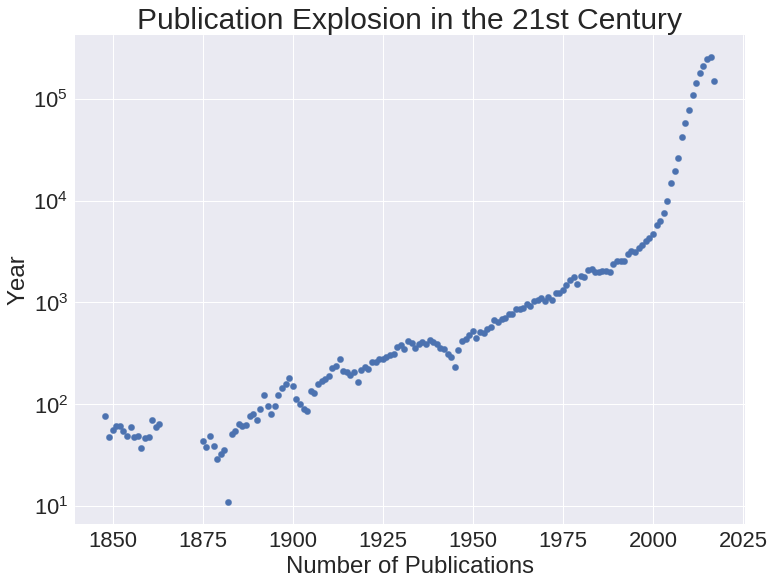

In [18]:
# number of publications by year
pub_by_year = df.pub_year.value_counts().sort_index()


fig = plt.figure(figsize=(12, 9))
ax = fig.gca()
ax.scatter(pub_by_year.index, pub_by_year, s=40)
ax.set_yscale('log')
ax.set_title('Publication Explosion in the 21st Century', fontsize=30)
ax.set_xlabel('Number of Publications', fontsize=24)
ax.set_ylabel('Year', fontsize=24)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(22)
plt.show()
# note the last data point is for the year 2017 (incomplete)

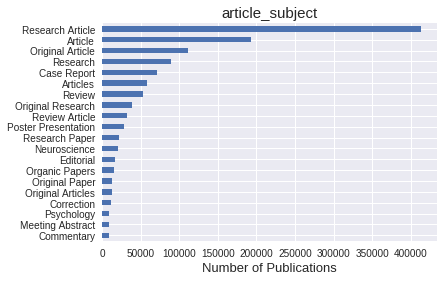

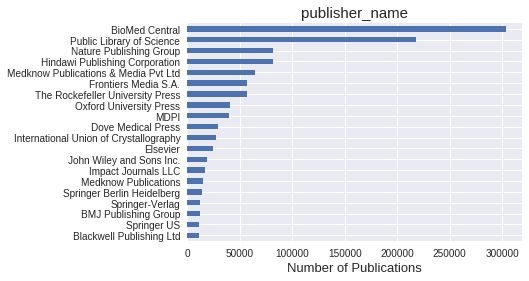

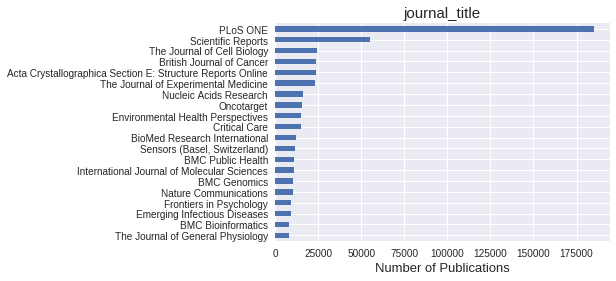

In [22]:
# check out some top categories
cols = ['article_subject', 'publisher_name', 'journal_title']
top20_categories = [df[col].value_counts(ascending=True).tail(20) for col in cols]
for index, col in enumerate(cols):
    top20_categories[index].plot(kind='barh')
    plt.title(col, fontsize=15)
    plt.xlabel('Number of Publications', fontsize=13)
    plt.show()

__Note:__  
The numbers here do not represent the actual numbers of publications from these publishers/journals. They are the numbers of publications made available through PubMed Central. For example, the journal _PLoS ONE_ greatly outnumbers the other journals because all of its publications are open access.

## Data Cleaning

#### Remove data that are non-essential or duplicated

In [ ]:
# drop some columns
df.drop(['file_path', 'pmid', 'doi', 'pub_month', 'pub_day'], axis=1, inplace=True)

# drop the rows with no abstract/title info
df.drop(no_text_info.index, axis=0, inplace=True)

In [29]:
# customized eda function
eda(df, head=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1669262 entries, 0 to 1669758
Data columns (total 8 columns):
pmc                1669262 non-null int64
article_subject    1669191 non-null object
pub_year           1669262 non-null int64
publisher_name     1617687 non-null object
journal_id         1669262 non-null object
journal_title      1669262 non-null object
article_title      1669257 non-null object
abstract           1474077 non-null object
dtypes: int64(2), object(6)
memory usage: 194.6+ MB


Number of nulls in each column:
pmc                     0
article_subject        71
pub_year                0
publisher_name      51575
journal_id              0
journal_title           0
article_title           5
abstract           195185
dtype: int64


                pmc      pub_year
count  1.669262e+06  1.669262e+06
mean   3.949237e+06  2.010800e+03
std    1.037021e+06  1.208552e+01
min    1.390000e+04  1.848000e+03
25%    3.262627e+06  2.011000e+03
50%    4.058264e+06  2.014000e+03

In [30]:
df.drop_duplicates(inplace=True)

In [31]:
# check if the pmc id for each publication is unique
df.pmc.nunique() == df.shape[0]

True

#### Missing data
Four columns have missing data (`article_subject`, `publisher_name`, `article_title`, `abstract`); I'll go through them one by one.

In [36]:
# publications without article subject information
df[df.article_subject.isnull()]

,pmc,article_subject,pub_year,publisher_name,journal_id,journal_title,article_title,abstract
24,3886293,NaN,2013,Blackwell Publishing Ltd,Ann Neurol,Annals of Neurology,Therapeutic advances in muscular dystrophy,The muscular dystrophies comprise a heterogeneous group of genetic disorders that produce progressive skeletal muscle weakness and wasting. There has been rapid growth and change in our understand...
28901,3494972,NaN,2010,Blackwell Publishing Ltd,Acta Psychiatr Scand,Acta Psychiatrica Scandinavica,The 5/95 gap in the indexation of psychiatric journals of low- and middle-income countries,"Mari JJ, Patel V, Kieling C, Razzouk D, Tyrer P, Herrman H. The 5/95 gap in the indexation of psychiatric journals of low- and middle-income countries.Objective:To investigate the relationship bet..."
46438,3321228,NaN,2012,Blackwell Publishing Ltd,APMIS,Apmis,Low-dosage metronomic chemotherapy and angiogenesis: topoisomerase inhibitors irinotecan and mitoxantrone stimulate VEGF-A-mediated angiogenesis,"Albertsson P, Lennernäs B, Norrby K. Low-dosage metronomic chemotherapy and angiogenesis: topoisomerase inhibitors irinotecan and mitoxantrone stimulate VEGF-A-mediated angiogenesis. APMIS 2011.Me..."
251198,3320658,NaN,2012,Blackwell Publishing Ltd,Child Adolesc Ment Health,Child and Adolescent Mental Health,Implementation quality of whole-school mental health promotion and students’ academic performance,BackgroundThis paper argues for giving explicit attention to the quality of implementation of school-wide mental health promotions and examines the impact of implementation quality on academic per...
255423,3531620,NaN,2009,Blackwell Publishing Ltd,Clin Microbiol Infect,Clinical Microbiology and Infection,Molecular detection of Bartonella species in rodents from the Lao PDR,NaN
306674,4703906,NaN,2016,Oxford University Press,Eur Heart J,European Heart Journal,Coronary artery bypass grafting-related bleeding complications in patients treated with ticagrelor or clopidogrel: a nationwide study,AimsExcessive bleeding impairs outcome after coronary artery bypass grafting (CABG). Current guidelines recommend withdrawal of clopidogrel and ticagrelor 5 days (120 h) before elective surgery. S...
306680,4823635,NaN,2016,Oxford University Press,Eur Heart J,European Heart Journal,The effect of cangrelor and access site on ischaemic and bleeding events: insights from CHAMPION PHOENIX,"AimsTo assess whether the use of the femoral or radial approach for percutaneous coronary intervention (PCI) interacted with the efficacy and safety of cangrelor, an intravenous P2Y12 inhibitor, i..."
306682,4929378,NaN,2016,Oxford University Press,Eur Heart J,European Heart Journal,Plasma ceramides predict cardiovascular death in patients with stable coronary artery disease and acute coronary syndromes beyond LDL-cholesterol,AimsThe aim was to study the prognostic value of plasma ceramides (Cer) as cardiovascular death (CV death) markers in three independent coronary artery disease (CAD) cohorts.Methods and resultsCor...
307115,2704939,NaN,2009,Blackwell Publishing Ltd,Eur J Haematol,European Journal of Haematology,High expression of BCL3 in human myeloma cells is associated with increased proliferation and inferior prognosis,Background:BCL3 is a putative oncogene encoding for a protein belonging to the inhibitory κB-family. We experienced that this putative oncogene was a common target gene for growth-promoting cytoki...
307132,3267050,NaN,2012,Blackwell Publishing Ltd,Eur J Haematol,European Journal of Haematology,The Medical Research Council Myeloma IX trial: the impact on treatment paradigms*,Osteolytic bone disease is a hallmark of symptomatic multiple myeloma. Bisphosphonates have been the mainstay of treatment to preserve skeletal integrity and prevent skeletal-related events in pat...


Most of the publications without article subject information still have valid title/abstract information; nothing too suspicious here.

In [40]:
# among the publications without publisher information,
# which journals are they from and how many (only showing the top 20)
df[df.publisher_name.isnull()].journal_title.value_counts().head(20)

British Journal of Cancer                   9904
Environmental Health Perspectives           9225
The Yale Journal of Biology and Medicine    5260
Medical History                             4555
The Ulster Medical Journal                  3132
Nature                                      2237
Oncogene                                    1066
Nature communications                        883
Nature neuroscience                          865
Nature structural & molecular biology        679
Nature genetics                              661
The Journal of investigative dermatology     507
Nature medicine                              492
Nature methods                               482
Obesity (Silver Spring, Md.)                 458
Nature immunology                            438
Nature chemical biology                      436
Nature cell biology                          420
Mediators of Inflammation                    346
Kidney international                         314
Name: journal_title,

A lot of these are prominent journals. Why is there no publisher information? When I have more time, I can go back and check the `.nxml` files to see if indeed no publisher information is provided, or it is stored under a different xpath. But for now, the publisher information is not that important. I shall move on.

In [47]:
# publications without article title information
df[df.article_title.isnull()]

,pmc,article_subject,pub_year,publisher_name,journal_id,journal_title,article_title,abstract
43199,3954366,Peri-Operative Care Series,2012,Royal College of Surgeons,Ann R Coll Surg Engl,Annals of The Royal College of Surgeons of England,NaN,"Diabetes is a common disease worldwide with a multitude of complications and high mortality. Moreover, its prevalence is increasing and many of our patients will have diabetes. We have known for a..."
68424,3036617,Research Article,2011,BioMed Central,BMC Genomics,BMC Genomics,NaN,"BackgroundDespite virtually identical DNA sequences between the sexes, sexual dimorphism is a widespread phenomenon in nature. To a large extent the systematic differences between the sexes must t..."
1132216,3020603,Research,2003,Centers for Disease Control and Prevention,Emerg Infect Dis,Emerging Infectious Diseases,NaN,Tungiasis is caused by infestation with the sand flea (Tunga penetrans). This ectoparasitosis is endemic in economically depressed communities in South American and African countries. Tungiasis is...
1140962,4663654,Original Article,2013,Leibniz Research Centre for Working Environment and Human Factors,EXCLI J,EXCLI Journal,NaN,Experimentally-induced total sleep deprivation (TSD) and chronic partial sleep restriction (CPSR) leads to the emergence of cognitive impairments. This is hypothesized to result from a consequent ...
1301859,2133526,Correction,1937,The Rockefeller University Press,J Exp Med,The Journal of Experimental Medicine,NaN,"Page 501, Table I, 3rd column, 3rd line of Experiment II, for 12/19/21 read 12/19/13."


In [49]:
# drop the last one since it doesn't contain much useful information
df.drop(1301859, axis=0, inplace=True)

In [50]:
# among the publications without abstract information,
# which article subject do they belong to and how many (only showing the top 20)
df[df.abstract.isnull()].article_subject.value_counts().head(20)

Poster Presentation      27526
Editorial                14198
Correction               11001
Articles                  9226
Meeting Abstract          9165
Book Review               7707
Oral Presentation         7128
Research Article          6947
Letter to the Editor      6155
Letters to the Editor     5435
Erratum                   4870
Book Reviews              4101
Letters to Editor         3412
Article                   3268
Letter                    2738
Commentary                2721
News                      2373
Correspondence            2359
Letter to Editor          1880
Neuroscience              1803
Name: article_subject, dtype: int64

In [58]:
df[(df.abstract.isnull()) & (df.article_subject=='Poster Presentation')].head(10)

,pmc,article_subject,pub_year,publisher_name,journal_id,journal_title,article_title,abstract
29641,4594147,Poster Presentation,2015,BioMed Central,Acta Vet Scand,Acta Veterinaria Scandinavica,Correlations between horse neck crest scoring and nape fat measurements obtained after image analysis,NaN
29642,4594150,Poster Presentation,2015,BioMed Central,Acta Vet Scand,Acta Veterinaria Scandinavica,Glycaemic and insulinaemic response to dietary fibre in horses,NaN
29649,4595024,Poster Presentation,2015,BioMed Central,Acta Vet Scand,Acta Veterinaria Scandinavica,Effect of physical activity on body condition in Swedish companion dogs,NaN
29653,4595095,Poster Presentation,2015,BioMed Central,Acta Vet Scand,Acta Veterinaria Scandinavica,Evaluation of body fat content and osteoarthritis in cats using computed tomography – a novel approach using whole-body imaging,NaN
29654,4595098,Poster Presentation,2015,BioMed Central,Acta Vet Scand,Acta Veterinaria Scandinavica,Minding the gap between theory and clinical practice: an individualised approach to the management of feline diabetes mellitus,NaN
29657,4595223,Poster Presentation,2015,BioMed Central,Acta Vet Scand,Acta Veterinaria Scandinavica,Fetal life malnutrition is not reflected in the relative abundance of adiponectin and leptin mRNA in adipose tissue in male mink kits at 9.5 weeks of age,NaN
29658,4595224,Poster Presentation,2015,BioMed Central,Acta Vet Scand,Acta Veterinaria Scandinavica,Testosterone and anti-Müllerian-hormone (AMH) in lean and overweight male Labrador Retrievers,NaN
29660,4595293,Poster Presentation,2015,BioMed Central,Acta Vet Scand,Acta Veterinaria Scandinavica,In vivo assessment of dog subcutaneous fat depots by real time ultrasonography and image analysis,NaN
29662,4595297,Poster Presentation,2015,BioMed Central,Acta Vet Scand,Acta Veterinaria Scandinavica,Energy requirements during weight loss and weight maintenance of two morbidly obese cats,NaN
29664,4595373,Poster Presentation,2015,BioMed Central,Acta Vet Scand,Acta Veterinaria Scandinavica,Relationships between body condition score and ultrasound skin-associated subcutaneous fat depth in equine,NaN


In [62]:
df[(df.abstract.isnull()) & (df.article_subject=='Correction')].head(10)

,pmc,article_subject,pub_year,publisher_name,journal_id,journal_title,article_title,abstract
29338,2880086,Correction,2010,BioMed Central,Acta Vet Scand,Acta Veterinaria Scandinavica,"Rumen-protected conjugated linoleic acid supplementation to dairy cows in late pregnancy and early lactation: effects on milk composition, milk yield, blood metabolites and gene expression in liver",NaN
29358,2930632,Correction,2010,BioMed Central,Acta Vet Scand,Acta Veterinaria Scandinavica,Seroprevalence of Borrelia burgdorferi sensu lato and Anaplasma phagocytophilum in Danish horses,NaN
31741,5054934,Correction,2015,John Wiley and Sons Inc.,Adv Sci (Weinh),Advanced Science,Fluorosurfactants‐Directed Preparation of Homogeneous and Hierarchical‐Porosity CMP Aerogels for Gas Sorption and Oil Cleanup,NaN
34438,5472745,Correction,2017,Impact Journals LLC,Aging (Albany NY),Aging (Albany NY),Correction: Patterns of brain atrophy associated with episodic memory and semantic fluency decline in aging,NaN
34450,5509461,Correction,2017,Impact Journals LLC,Aging (Albany NY),Aging (Albany NY),Correction: Early age decline in DNA repair capacity in the liver: in depth profile of differential gene expression,NaN
35370,3551669,Correction,2013,BioMed Central,AIDS Res Ther,AIDS Research and Therapy,"Correction: Total Lymphocyte Count as surrogate marker for CD4 Cell Count in HIV-Infected Individuals in Gondar University Hospital, Northwest Ethiopia",NaN
36242,3846441,Correction,2013,BioMed Central,Allergy Asthma Clin Immunol,"Allergy, Asthma, and Clinical Immunology : Official Journal of the Canadian Society of Allergy and Clinical Immunology",Correction: Predictive value of IgE/IgG4 antibody ratio in children with egg allergy,NaN
37006,3222311,Correction,2011,Springer,AMB Express,AMB Express,A simple method to evaluate the number of bradyrhizobia on soybean seeds and its implication on inoculant quality control,NaN
39522,3961014,Correction,2014,Kowsar,Anesth Pain Med,Anesthesiology and Pain Medicine,Corrigendum to: Is Fasting Duration Important in Post Adenotonsillectomy Feeding Time? [Published in Anesth Pain Med. 2014 January; 4(1): e10256],NaN
40872,2737534,Correction,2009,BioMed Central,Ann Clin Microbiol Antimicrob,Annals of Clinical Microbiology and Antimicrobials,Correction: Antifungal treatment for invasive Candida infections: a mixed treatment comparison meta-analysis,NaN


In [61]:
df[(df.abstract.isnull()) & (df.article_subject=='Articles')].head(10)

,pmc,article_subject,pub_year,publisher_name,journal_id,journal_title,article_title,abstract
544,3860403,Articles,2012,National Institute on Alcohol Abuse and Alcoholism,Alcohol Res,Alcohol Research : Current Reviews,Genetic and Genomic Web Resources for Research on Alcohol Use and Abuse,NaN
555,3860415,Articles,2012,National Institute on Alcohol Abuse and Alcoholism,Alcohol Res,Alcohol Research : Current Reviews,Genetics Primer,NaN
575,3908709,Articles,2014,National Institute on Alcohol Abuse and Alcoholism,Alcohol Res,Alcohol Research : Current Reviews,APIS: The NIAAA Alcohol Policy Information System,NaN
582,3908716,Articles,2014,National Institute on Alcohol Abuse and Alcoholism,Alcohol Res,Alcohol Research : Current Reviews,The World Health organization’s Global Monitoring System on Alcohol and Health,NaN
700,3860545,Articles,2011,National Institute on Alcohol Abuse and Alcoholism,Alcohol Res Health,Alcohol Research & Health,The Quest for a Neurobehavioral Profile of Heavy Prenatal Alcohol Exposure,NaN
701,3860546,Articles,2011,National Institute on Alcohol Abuse and Alcoholism,Alcohol Res Health,Alcohol Research & Health,Combination Drug Use and Risk for Fetal Harm,NaN
725,3860449,Articles,2008,National Institute on Alcohol Abuse and Alcoholism,Alcohol Res Health,Alcohol Research & Health,NIH Roadmap for Medical Research,NaN
733,3860457,Articles,2008,National Institute on Alcohol Abuse and Alcoholism,Alcohol Res Health,Alcohol Research & Health,Timing of Alcohol and Other Drug Use,NaN
773,3860560,Articles,2011,National Institute on Alcohol Abuse and Alcoholism,Alcohol Res Health,Alcohol Research & Health,Understanding the Effects of Prenatal Alcohol Exposure Using Three Dimensional Facial Imaging,NaN
775,3860562,Articles,2011,National Institute on Alcohol Abuse and Alcoholism,Alcohol Res Health,Alcohol Research & Health,The Alcohol Policy Information System (APIS) and Policy Research At NIAAA,NaN


At a glance, even though these publications don't have abstract information, the article titles can still provide useful information. Therefore I'll keep them.  
Again, when I have more time, I would like to go back and check the `.nxml` files to see why no abstract information was extracted. But for now, I feel like I have enough data, so I shall move on.

In [66]:
# the percentage of missing data in each column
df.isnull().sum() / len(df)

pmc                0.000000
article_subject    0.000043
pub_year           0.000000
publisher_name     0.030897
journal_id         0.000000
journal_title      0.000000
article_title      0.000002
abstract           0.116929
dtype: float64

In [64]:
# save the cleaned dataframe to another csv
df.to_csv('/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/pmc_clean.csv', 
          index=False, chunksize=1000)

## Modeling
To analyze topics that change over time, I use the Dynamic Topic Models (implemented in C/C++) developed by David M. Blei and Sean M. Gerrish.   
  
Following the README in their [GitHub repo](https://github.com/blei-lab/dtm), these were the steps I took to install the software in Ubuntu 16.04 LTS:
- Install GSL (GNU Scientific Library):  
`sudo apt-get install libgsl-dev`
- Fork and clone the repo
- In the terminal:
    - `cd` into the cloned repo, then `cd dtm` to go to the subdirectory
    - Run the following command to compile:  
    `make`  
    
(If everything is compiled without no error (fingers crossed), there should now be a `main` executable in the `dtm` subdirectory.)

### Prepare input files for the software
According to the [instructions](https://github.com/blei-lab/dtm/blob/67139e6f526b2bc33aef56dc36176a1b8b210056/dtm/sample.sh#L6), the software takes two input files:
> (a) foo-mult.dat, which is one-doc-per-line, each line of the form

>   unique_word_count index1:count1 index2:count2 ... indexn:countn

>   where each index is an integer corresponding to a unique word.

> (b) foo-seq.dat, which is of the form

>   Number_Timestamps  
>   number_docs_time_1  
>   ...  
>   number_docs_time_i  
>   ...  
>   number_docs_time_NumberTimestamps  

> - The docs in foo-mult.dat should be ordered by date, with the first docs from time1, the next from time2, ..., and the last docs from timen.
  
The following steps are to prepare these input files from the csv obtained from the data cleaning step. Also created are a file with all of the words in the vocabulary and their indices, and a file with information on each of the documents, arranged in the same order as input file a (the -mult.dat file).

In [4]:
df = pd.read_csv('/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/pmc_clean.csv', 
                 index_col='pmc')

/home/fay/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


---
#### Proof of Concept: Modeling with the articles from _The Journal of Cell Biology_

In [5]:
jcb = df[df.journal_title == 'The Journal of Cell Biology'].copy()
# customized eda function
eda(jcb)

Head of the dataframe:

           article_subject  pub_year                    publisher_name  \
pmc                                                                      
5004445  Research Articles      2016  The Rockefeller University Press   
5294785  Research Articles      2017  The Rockefeller University Press   
5350508  Research Articles      2017  The Rockefeller University Press   
5350509  Research Articles      2017  The Rockefeller University Press   
5379941  Research Articles      2017  The Rockefeller University Press   

          journal_id                journal_title  \
pmc                                                 
5004445  J Cell Biol  The Journal of Cell Biology   
5294785  J Cell Biol  The Journal of Cell Biology   
5350508  J Cell Biol  The Journal of Cell Biology   
5350509  J Cell Biol  The Journal of Cell Biology   
5379941  J Cell Biol  The Journal of Cell Biology   

                                                                                     

The duplicates don't seem to contain much useful information on article title/abstract; they should be removed.

In [6]:
jcb.drop_duplicates(keep=False, inplace=True)
# customized eda function
eda(jcb)

Head of the dataframe:

           article_subject  pub_year                    publisher_name  \
pmc                                                                      
5004445  Research Articles      2016  The Rockefeller University Press   
5294785  Research Articles      2017  The Rockefeller University Press   
5350508  Research Articles      2017  The Rockefeller University Press   
5350509  Research Articles      2017  The Rockefeller University Press   
5379941  Research Articles      2017  The Rockefeller University Press   

          journal_id                journal_title  \
pmc                                                 
5004445  J Cell Biol  The Journal of Cell Biology   
5294785  J Cell Biol  The Journal of Cell Biology   
5350508  J Cell Biol  The Journal of Cell Biology   
5350509  J Cell Biol  The Journal of Cell Biology   
5379941  J Cell Biol  The Journal of Cell Biology   

                                                                                     

In [7]:
def prepare_dat_files(df, sorted_df_path, word2id_path, file_a_path, file_b_path):
    df = df.copy()

    # combine article title and abstract
    df['text'] = df.article_title.str.cat(df.abstract, sep=' ', na_rep=' ')
    assert df.text.isnull().sum() == 0, 'Article title/abstract cannot be null'
    print('Number of articles: {}'.format(len(df)))

    df.sort_values(by='pub_year', inplace=True)
    # save the sorted dataframe
    df.drop('text', axis=1).to_csv(sorted_df_path, chunksize=5000)
    print('Sorted csv saved at {!r}\n'.format(sorted_df_path))

    # prepare file a
    vect = vectorize(df.text, word2id_path)
    prepare_file_a(file_a_path, vect)

    # prepare file b
    prepare_file_b(file_b_path, df)


my_stopwords = {'et', 'al', 'ml'}
stopwords = set(nltk_stopwords.words('english')) | my_stopwords

def my_tokenizer(string, stopwords=stopwords):
    string = string.lower()

    tokens = re.findall(r'\b([a-z][a-z0-9]+)\b', string)

    # lemmatization
    tokens = [WordNetLemmatizer().lemmatize(token)
              for token in tokens
              if token not in stopwords]

    return tokens


def vectorize(corpus, word2id_path):
    start = time.time()
    vectorizer = CountVectorizer(tokenizer=my_tokenizer, min_df=20)
    data = vectorizer.fit_transform(corpus)

    word2id = vectorizer.vocabulary_
    print('Number of words in vocabulary: {}'.format(len(word2id)))

    # save the vocabulary and corresponding indices
    append_to_csv(word2id_path, ['word', 'index'])  # header
    for word, ind in word2id.items():
        append_to_csv(word2id_path, [word, ind])
    print('Vocabulary and corresponding indices saved at {!r}'.format(
        word2id_path))

    print('vectorize run time: {:.1f} minutes.\n'.format((time.time()-start)/60))

    return data


def prepare_file_a(file_path, sparse_csr_mat):
    start = time.time()
    index_pointers = sparse_csr_mat.indptr
    word_counts = sparse_csr_mat.data
    word_indices = sparse_csr_mat.indices

    for i in range(len(index_pointers) - 1):
        indices = word_indices[index_pointers[i]: index_pointers[i + 1]]
        counts = word_counts[index_pointers[i]: index_pointers[i + 1]]
        line = str(len(indices))
        for j, index in enumerate(indices):
            line += ' {}:{}'.format(index, counts[j])
        with open(file_path, 'a') as f:
            f.write(line + '\n')

    print('file_a saved at {!r}'.format(file_path))
    print('prepare_file_a run time: {:.1f} minutes.\n'.format(
        (time.time() - start) / 60))


def prepare_file_b(file_path, df):
    start = time.time()
    df_by_year = df.groupby('pub_year').text.agg(len)

    with open(file_path, 'a') as f:
        f.write('{}\n'.format(len(df_by_year)))
        for num_doc in df_by_year:
            f.write(str(num_doc) + '\n')

    print('file_b save at {!r}'.format(file_path))
    print('prepare_file_b run time:{:.1f} minutes.\n'.format(
        (time.time() - start) / 60))

In [8]:
!mkdir '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/'

In [9]:
sorted_df_path = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/jcb_sorted.csv'
word2id_path = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/word2id.csv'
file_a_path = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/jcb-mult.dat'
file_b_path = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/jcb-seq.dat'

In [10]:
%%time
prepare_dat_files(jcb, sorted_df_path, word2id_path, file_a_path, file_b_path)

Number of articles: 23896
Sorted csv saved at '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/jcb_sorted.csv'

Number of words in vocabulary: 6619
Vocabulary and corresponding indices saved at '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/word2id.csv'
vectorize run time: 0.3 minutes.

file_a saved at '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/jcb-mult.dat'
prepare_file_a run time: 0.1 minutes.

file_b save at '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/jcb-seq.dat'
prepare_file_b run time:0.0 minutes.

CPU times: user 17.7 s, sys: 1.19 s, total: 18.9 s
Wall time: 21 s


### Run the software using command lines
The following command lines are adapted from [this example](https://github.com/blei-lab/dtm/blob/67139e6f526b2bc33aef56dc36176a1b8b210056/dtm/sample.sh#L73).  
[Skip the output of the next cell and jump to [process output](#Process-output)]

In [11]:
%%time
! /home/fay/code/dtm/dtm/main \
  --ntopics=10 \
  --mode=fit \
  --rng_seed=0 \
  --initialize_lda=true \
  --corpus_prefix='/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/jcb' \
  --outname='/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run' \
  --top_chain_var=0.005 \
  --alpha=0.01 \
  --lda_sequence_min_iter=6 \
  --lda_sequence_max_iter=20 \
  --lda_max_em_iter=10

### INITIALIZING MODEL FROM LDA ###

data file: /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/jcb
reading corpus from /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/jcb-mult.dat
read corpus (ndocs = 23896; nterms = 6619; nwords = 2242656)

RANDOM SEED = 1504575559
e-step: processing doc 1000
e-step: processing doc 2000
e-step: processing doc 3000
e-step: processing doc 4000
e-step: processing doc 5000
e-step: processing doc 6000
e-step: processing doc 7000
e-step: processing doc 8000
e-step: processing doc 9000
e-step: processing doc 10000
e-step: processing doc 11000
e-step: processing doc 12000
e-step: processing doc 13000
e-step: processing doc 14000
e-step: processing doc 15000
e-step: processing doc 16000
e-step: processing doc 17000
e-step: processing doc 18000
e-step: processing doc 19000
e-step: processing doc 20000
e-step: processing doc 21000
e-step: processing doc 22000
e-step: processing doc 23000
initial 

e-step: processing doc 11000
e-step: processing doc 12000
e-step: processing doc 13000
e-step: processing doc 14000
e-step: processing doc 15000
e-step: processing doc 16000
e-step: processing doc 17000
e-step: processing doc 18000
e-step: processing doc 19000
e-step: processing doc 20000
e-step: processing doc 21000
e-step: processing doc 22000
e-step: processing doc 23000
iter   = 10
lhood  = -16237799.185
m, e lhood  =      0.000, -16237799.185
conv   =  4.407e-04

max_iter: 10

writing 6619 x 10 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//initial-lda.beta
writing 10 vector to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//initial-lda.alpha
writing 6619 x 10 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//initial-lda-ss.dat
fitting.. 

### FITTING DYNAMIC TOPIC MODEL ###

reading corpus from /media/fay/38E0D529E0D4EE5E/Users/Fay

writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-006-var-e-log-prob.dat

writing topic 007
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-007-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-007-var-e-log-prob.dat

writing topic 008
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-008-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-008-var-e-log-prob.dat

writing topic 009
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-009-var-obs.dat
writing 6619 x 56 matr

writing 23896 x 11 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq//lhoods.dat

M step

fitting topic 00
Computing bound, all times.
initial sslm bound = -2176325.78669
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -2175424.33713; conv =  4.14207e-04
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -2175081.92034; conv =  1.57402e-04

fitting topic 01
Computing bound, all times.
initial sslm bound = -2018487.62970
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -2017302.91372; conv =  5.86932e-04
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -2016808.86644; conv =  2.44905e-04

fitting topic 02
Computing bound, all times.
initial sslm bound = -1972085.23413
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -1971447.65226; conv =  3.23303e-04
Updating term 0
Upda

Computing bound, all times.
initial sslm bound = -1355585.48891
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -1354352.11025; conv =  9.09849e-04
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -1354479.18377; conv =  9.38261e-05

fitting topic 05
Computing bound, all times.
initial sslm bound = -1706326.20304
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -1706136.33306; conv =  1.11274e-04
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -1705801.52419; conv =  1.96238e-04

fitting topic 06
Computing bound, all times.
initial sslm bound = -2457664.21740
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -2456702.82360; conv =  3.91182e-04
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -2456514.16726; conv =  7.67925e-05

fitting topic 07
Computing bound, all times.
initial sslm bound = -17

(01) sslm bound = -2016745.20029; conv =  1.89792e-04
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -2016510.58875; conv =  1.16332e-04

fitting topic 09
Computing bound, all times.
initial sslm bound = -1931741.95440
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -1931428.86321; conv =  1.62077e-04
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -1931438.59074; conv =  5.03644e-06

writing topic 000
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-000-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-000-var-e-log-prob.dat

writing topic 001
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-001-var-obs.dat
writing 6619 x 56 


writing topic 003
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-003-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-003-var-e-log-prob.dat

writing topic 004
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-004-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-004-var-e-log-prob.dat

writing topic 005
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-005-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-005-var-e-log-prob.dat

writing topic 006
wri

writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-007-var-e-log-prob.dat

writing topic 008
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-008-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-008-var-e-log-prob.dat

writing topic 009
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-009-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-009-var-e-log-prob.dat

(06) lda seq bound=-35666915.4643800; heldout bound=      0.0000000, conv=  8.4390742e-04


EM iter   7

E step

writing 23896 x 10 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/

Updating term 5000
Computing bound, all times.
(02) sslm bound = -2178255.47088; conv =  1.41561e-04

fitting topic 01
Computing bound, all times.
initial sslm bound = -1897676.88120
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -1897429.47038; conv =  1.30376e-04
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -1897538.96823; conv =  5.77085e-05

fitting topic 02
Computing bound, all times.
initial sslm bound = -2028939.28837
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -2028897.98034; conv =  2.03594e-05
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -2028812.46212; conv =  4.21501e-05

fitting topic 03
Computing bound, all times.
initial sslm bound = -2427466.94712
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -2427082.42020; conv =  1.58407e-04
Updating term 0
Updating term 5000
Computing bound, all times.
(02) 

Computing bound, all times.
initial sslm bound = -1639807.81076
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -1639591.92239; conv =  1.31655e-04
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -1639558.50889; conv =  2.03792e-05

fitting topic 06
Computing bound, all times.
initial sslm bound = -2411483.64775
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -2411389.96323; conv =  3.88493e-05
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -2411388.07651; conv =  7.82419e-07

fitting topic 07
Computing bound, all times.
initial sslm bound = -1768241.33291
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -1767995.16702; conv =  1.39215e-04
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -1768270.54285; conv =  1.55756e-04

fitting topic 08
Computing bound, all times.
initial sslm bound = -19

(01) sslm bound = -1914148.29686; conv =  1.49887e-04
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -1914217.45346; conv =  3.61292e-05

writing topic 000
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-000-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-000-var-e-log-prob.dat

writing topic 001
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-001-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-001-var-e-log-prob.dat

writing topic 002
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-002-var-obs.dat
writing 


writing topic 004
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-004-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-004-var-e-log-prob.dat

writing topic 005
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-005-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-005-var-e-log-prob.dat

writing topic 006
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-006-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-006-var-e-log-prob.dat

writing topic 007
wri

writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-008-var-e-log-prob.dat

writing topic 009
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-009-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-009-var-e-log-prob.dat

(12) lda seq bound=-35561095.3849908; heldout bound=      0.0000000, conv=  3.5671601e-04


EM iter  13

E step

writing 23896 x 10 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq//gam.dat
writing 23896 x 11 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq//lhoods.dat

M step

fitting topic 00
Computing bound, all times.
initial sslm bound = -2176713.49491
Updating term 0
Updating term 5000

Computing bound, all times.
initial sslm bound = -2022511.50012
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -2022522.55310; conv =  5.46498e-06
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -2022478.97316; conv =  2.15473e-05

fitting topic 03
Computing bound, all times.
initial sslm bound = -2502399.29709
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -2502316.42027; conv =  3.31189e-05
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -2502277.77766; conv =  1.54427e-05

fitting topic 04
Computing bound, all times.
initial sslm bound = -1284079.62198
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -1284032.79048; conv =  3.64709e-05
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -1283990.18369; conv =  3.31820e-05

fitting topic 05
Computing bound, all times.
initial sslm bound = -16

(01) sslm bound = -2384000.28730; conv =  8.72664e-05
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -2384094.84695; conv =  3.96643e-05

fitting topic 07
Computing bound, all times.
initial sslm bound = -1764143.38737
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -1764056.07465; conv =  4.94930e-05
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -1764027.69907; conv =  1.60854e-05

fitting topic 08
Computing bound, all times.
initial sslm bound = -1973013.57217
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -1972850.13002; conv =  8.28388e-05
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -1973034.76488; conv =  9.35879e-05

fitting topic 09
Computing bound, all times.
initial sslm bound = -1891919.46039
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -1891807.12060; conv =  5.93787e-0


writing topic 001
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-001-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-001-var-e-log-prob.dat

writing topic 002
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-002-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-002-var-e-log-prob.dat

writing topic 003
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-003-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-003-var-e-log-prob.dat

writing topic 004
wri


writing topic 006
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-006-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-006-var-e-log-prob.dat

writing topic 007
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-007-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-007-var-e-log-prob.dat

writing topic 008
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-008-var-obs.dat
writing 6619 x 56 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq/topic-008-var-e-log-prob.dat

writing topic 009
wri

writing 23896 x 11 matrix to /media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run//lda-seq//lhoods.dat

M step

fitting topic 00
Computing bound, all times.
initial sslm bound = -2167404.72339
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -2167588.33498; conv =  8.47150e-05
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -2167392.11609; conv =  9.05241e-05

fitting topic 01
Computing bound, all times.
initial sslm bound = -1835429.78086
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -1835351.27585; conv =  4.27720e-05
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -1835365.00481; conv =  7.48029e-06

fitting topic 02
Computing bound, all times.
initial sslm bound = -2007405.66148
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -2007333.44132; conv =  3.59769e-05
Updating term 0
Upda


fitting topic 04
Computing bound, all times.
initial sslm bound = -1278456.91166
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -1278483.78043; conv =  2.10166e-05
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -1278474.07071; conv =  7.59471e-06

fitting topic 05
Computing bound, all times.
initial sslm bound = -1648808.47955
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -1648863.37541; conv =  3.32943e-05
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -1648820.54980; conv =  2.59728e-05

fitting topic 06
Computing bound, all times.
initial sslm bound = -2372672.78551
Updating term 0
Updating term 5000
Computing bound, all times.
(01) sslm bound = -2372593.32582; conv =  3.34895e-05
Updating term 0
Updating term 5000
Computing bound, all times.
(02) sslm bound = -2372598.29415; conv =  2.09405e-06

fitting topic 07
Computing bound, all times.
initia

### Process output

In [19]:
sorted_df_path = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/jcb_sorted.csv'
word2id_path = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/word2id.csv'

In [20]:
jcb = pd.read_csv(sorted_df_path, index_col='pmc')
jcb.head(3)

,article_subject,pub_year,publisher_name,journal_id,journal_title,article_title,abstract
pmc,,,,,,,
2106030,Article,1962,The Rockefeller University Press,J Cell Biol,The Journal of Cell Biology,ACROSOME FORMATION IN THE HOUSE CRICKET,"Acrosome formation during spermatogenesis in the house cricket was studied with the electron microscope. In the early spermatid there is a single Golgi body, called the acroblast, which is cup-sha..."
2106133,Article,1962,The Rockefeller University Press,J Cell Biol,The Journal of Cell Biology,SPECULATIONS BASED ON THE MORPHOLOGY OF THE GOLGI SYSTEMS IN SEVERAL TYPES OF PROTEIN-SECRETING CELLS,Electron microscopical observations on the relationship of the Golgi region to other intracellular organelles in certain protein-secreting cells have substantiated and extended existing hypotheses...
2106132,Brief Notes,1962,The Rockefeller University Press,J Cell Biol,The Journal of Cell Biology,CYTOLYSOMES AND MITOCHONDRIAL DEGENERATION,NaN


In [29]:
vocab = pd.read_csv(word2id_path, index_col='index').sort_index()
vocab.tail()

,word
index,
6614,zonula
6615,zonulae
6616,zygote
6617,zygotic
6618,zymogen


According to the [documentation](https://github.com/blei-lab/dtm/blob/67139e6f526b2bc33aef56dc36176a1b8b210056/dtm/sample.sh#L37), the output files created by the Dynamic Topic Modeling software include:  
> - topic-???-var-e-log-prob.dat: the e-betas (word distributions) for topic ??? for all times.  This is in row-major form.
> - gam.dat: The gammas associated with each document.  Divide these by the sum for each document to get expected topic mixtures.

In [21]:
def read_topic_word_dist(topic, journal_df, output_prefix):
    word_dist_file = output_prefix + str(topic) + '-var-e-log-prob.dat'
    word_dist = np.fromfile(word_dist_file, sep='\n')
    
    # reshape the numpy array
    ncols = journal_df.pub_year.nunique()
    nrows = len(vocab)
    word_dist = np.reshape(word_dist, (nrows, ncols))
    
    # convert the numpy ndarray to pandas dataframe
    return pd.DataFrame(word_dist, 
                        columns=np.sort(journal_df.pub_year.unique()).tolist())

In [22]:
def top_words(topic_word_dist, vocab, year, num_words=10):
    indices = topic_word_dist.loc[:,year].sort_values(ascending=False).head(num_words).index
    return vocab.loc[indices, :]

In [32]:
def all_top_words(topics, journal_df, vocab, ouput_prefix):
    for topic in topics:
        word_dist = read_topic_word_dist(topic, journal_df, output_prefix)
        print('Topic {}'.format(topic))
        for year in np.sort(journal_df.pub_year.unique()):
            print("{}:\n{}\n".format(year, top_words(word_dist, vocab, year, 20).word.tolist()))
        print('-'*25)

In [33]:
output_prefix = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run/lda-seq/topic-0'
n_topics = 10
topics = [str(i) if i > 9 else '0' + str(i) for i in range(n_topics)]

all_top_words(topics, jcb, vocab, output_prefix)

Topic 00
1962:
['muscle', 'filament', 'fiber', 'band', 'microtubule', 'length', 'myofibril', 'flagellum', 'protein', 'cilium', 'sarcomere', 'thick', 'contraction', 'myosin', 'two', 'skeletal', 'thin', 'line', 'flagellar', 'actin']

1963:
['muscle', 'filament', 'fiber', 'band', 'microtubule', 'length', 'myofibril', 'flagellum', 'protein', 'cilium', 'sarcomere', 'thick', 'contraction', 'myosin', 'two', 'skeletal', 'thin', 'line', 'flagellar', 'actin']

1964:
['muscle', 'filament', 'fiber', 'band', 'microtubule', 'length', 'protein', 'flagellum', 'myofibril', 'cilium', 'sarcomere', 'thick', 'contraction', 'myosin', 'two', 'thin', 'skeletal', 'line', 'flagellar', 'actin']

1965:
['muscle', 'filament', 'fiber', 'band', 'microtubule', 'length', 'protein', 'flagellum', 'myofibril', 'cilium', 'sarcomere', 'thick', 'contraction', 'myosin', 'two', 'thin', 'skeletal', 'line', 'actin', 'flagellar']

1966:
['muscle', 'filament', 'fiber', 'band', 'microtubule', 'length', 'protein', 'flagellum', 'cil

Topic 01
1962:
['cell', 'ferritin', 'peroxidase', 'surface', 'blood', 'antibody', 'uptake', 'membrane', 'capillary', 'lymphocyte', 'antigen', 'vesicle', 'labeled', 'site', 'kidney', 'albumin', 'protein', 'endothelial', 'rabbit', 'endothelium']

1963:
['cell', 'ferritin', 'peroxidase', 'surface', 'blood', 'antibody', 'uptake', 'membrane', 'capillary', 'lymphocyte', 'antigen', 'vesicle', 'site', 'labeled', 'kidney', 'albumin', 'protein', 'endothelial', 'rabbit', 'rat']

1964:
['cell', 'ferritin', 'peroxidase', 'surface', 'blood', 'antibody', 'uptake', 'membrane', 'capillary', 'lymphocyte', 'antigen', 'vesicle', 'site', 'labeled', 'kidney', 'albumin', 'protein', 'endothelial', 'rat', 'rabbit']

1965:
['cell', 'peroxidase', 'ferritin', 'surface', 'blood', 'antibody', 'membrane', 'uptake', 'capillary', 'lymphocyte', 'antigen', 'vesicle', 'site', 'labeled', 'kidney', 'albumin', 'protein', 'endothelial', 'rat', 'binding']

1966:
['cell', 'peroxidase', 'ferritin', 'surface', 'blood', 'antibody

Topic 02
1962:
['nucleus', 'dna', 'cell', 'synthesis', 'chromosome', 'nuclear', 'hour', 'thymidine', 'mitotic', 'time', 'protein', 'oocyte', 'division', 'mitosis', 'egg', 'cycle', 'labeled', 'cent', 'stage', 'h3']

1963:
['nucleus', 'dna', 'cell', 'synthesis', 'chromosome', 'nuclear', 'hour', 'thymidine', 'mitotic', 'time', 'protein', 'division', 'oocyte', 'mitosis', 'egg', 'cycle', 'labeled', 'stage', 'period', 'h3']

1964:
['dna', 'nucleus', 'cell', 'synthesis', 'nuclear', 'chromosome', 'hour', 'thymidine', 'mitotic', 'time', 'division', 'protein', 'oocyte', 'egg', 'mitosis', 'cycle', 'stage', 'labeled', 'period', 'h3']

1965:
['dna', 'nucleus', 'cell', 'synthesis', 'nuclear', 'chromosome', 'thymidine', 'mitotic', 'time', 'division', 'hour', 'protein', 'cycle', 'oocyte', 'egg', 'mitosis', 'stage', 'period', 'labeled', 'chromatin']

1966:
['dna', 'nucleus', 'cell', 'nuclear', 'synthesis', 'chromosome', 'thymidine', 'mitotic', 'division', 'time', 'cycle', 'protein', 'egg', 'oocyte', 'm

Topic 03
1962:
['protein', 'fraction', 'acid', 'granule', 'golgi', 'liver', 'membrane', 'activity', 'ribosome', 'virus', 'rat', 'chloroplast', 'endoplasmic', 'isolated', 'enzyme', 'centrifugation', 'phosphatase', 'density', 'sucrose', 'gradient']

1963:
['protein', 'fraction', 'acid', 'granule', 'golgi', 'liver', 'membrane', 'activity', 'ribosome', 'virus', 'rat', 'chloroplast', 'endoplasmic', 'isolated', 'enzyme', 'centrifugation', 'phosphatase', 'density', 'sucrose', 'gradient']

1964:
['protein', 'fraction', 'acid', 'granule', 'golgi', 'liver', 'membrane', 'activity', 'ribosome', 'rat', 'virus', 'chloroplast', 'endoplasmic', 'isolated', 'enzyme', 'centrifugation', 'density', 'phosphatase', 'gradient', 'sucrose']

1965:
['protein', 'fraction', 'acid', 'golgi', 'granule', 'liver', 'membrane', 'activity', 'ribosome', 'rat', 'chloroplast', 'endoplasmic', 'virus', 'enzyme', 'isolated', 'centrifugation', 'density', 'gradient', 'phosphatase', 'reticulum']

1966:
['protein', 'fraction', 'ac

Topic 04
1962:
['nerve', 'axon', 'neuron', 'myelin', 'sheath', 'synaptic', 'process', 'ganglion', 'fiber', 'terminal', 'vesicle', 'brain', 'glial', 'schwann', 'cone', 'nervous', 'neuronal', 'axonal', 'synapsis', 'cell']

1963:
['nerve', 'axon', 'neuron', 'myelin', 'sheath', 'synaptic', 'process', 'fiber', 'ganglion', 'terminal', 'vesicle', 'brain', 'glial', 'schwann', 'cone', 'nervous', 'neuronal', 'axonal', 'synapsis', 'cell']

1964:
['nerve', 'axon', 'neuron', 'myelin', 'sheath', 'synaptic', 'fiber', 'process', 'ganglion', 'terminal', 'vesicle', 'brain', 'glial', 'schwann', 'cone', 'nervous', 'neuronal', 'axonal', 'synapsis', 'cell']

1965:
['nerve', 'axon', 'neuron', 'myelin', 'sheath', 'synaptic', 'fiber', 'ganglion', 'terminal', 'process', 'vesicle', 'brain', 'glial', 'schwann', 'cone', 'nervous', 'neuronal', 'axonal', 'synapsis', 'cell']

1966:
['nerve', 'axon', 'neuron', 'myelin', 'sheath', 'synaptic', 'fiber', 'ganglion', 'terminal', 'process', 'vesicle', 'brain', 'schwann', 'g

Topic 05
1962:
['cell', 'intercellular', 'contact', 'adhesion', 'junction', 'substrate', 'movement', 'kinase', 'epidermal', 'fibroblast', 'cellular', 'microfilaments', 'spreading', 'protein', 'epithelial', 'phosphorylation', 'adhesive', 'induced', 'stress', 'egf']

1963:
['cell', 'intercellular', 'contact', 'adhesion', 'junction', 'substrate', 'movement', 'kinase', 'epidermal', 'fibroblast', 'cellular', 'microfilaments', 'spreading', 'protein', 'epithelial', 'phosphorylation', 'adhesive', 'induced', 'stress', 'egf']

1964:
['cell', 'intercellular', 'contact', 'adhesion', 'junction', 'substrate', 'movement', 'kinase', 'epidermal', 'fibroblast', 'cellular', 'microfilaments', 'spreading', 'protein', 'epithelial', 'phosphorylation', 'adhesive', 'induced', 'stress', 'egf']

1965:
['cell', 'intercellular', 'contact', 'adhesion', 'junction', 'substrate', 'movement', 'kinase', 'epidermal', 'fibroblast', 'microfilaments', 'cellular', 'protein', 'spreading', 'phosphorylation', 'epithelial', 'adh

Topic 06
1962:
['electron', 'membrane', 'structure', 'cell', 'body', 'particle', 'fine', 'material', 'microscope', 'section', 'granule', 'microscopy', 'found', 'study', 'dense', 'mitochondrion', 'surface', 'fixed', 'within', 'reticulum']

1963:
['electron', 'membrane', 'structure', 'cell', 'body', 'fine', 'particle', 'material', 'microscope', 'section', 'granule', 'microscopy', 'found', 'study', 'dense', 'surface', 'mitochondrion', 'reticulum', 'fixed', 'within']

1964:
['electron', 'membrane', 'structure', 'cell', 'body', 'fine', 'material', 'microscope', 'particle', 'granule', 'section', 'microscopy', 'found', 'surface', 'dense', 'study', 'reticulum', 'mitochondrion', 'within', 'cytoplasm']

1965:
['membrane', 'electron', 'structure', 'cell', 'body', 'material', 'fine', 'granule', 'microscope', 'particle', 'section', 'microscopy', 'surface', 'found', 'dense', 'reticulum', 'study', 'within', 'vesicle', 'cytoplasm']

1966:
['membrane', 'electron', 'structure', 'cell', 'body', 'material

Topic 07
1962:
['rna', 'nucleolus', 'synthesis', 'cell', 'nucleolar', 'dna', 'protein', 'type', 'actinomycin', 'mutant', 'ribosomal', 'nuclear', 'strain', 'chromosome', 'drosophila', 'precursor', 'cytoplasmic', 'uridine', 'nucleic', 'gland']

1963:
['rna', 'nucleolus', 'synthesis', 'cell', 'nucleolar', 'dna', 'protein', 'actinomycin', 'type', 'mutant', 'ribosomal', 'strain', 'nuclear', 'chromosome', 'drosophila', 'precursor', 'cytoplasmic', 'uridine', 'gland', 'normal']

1964:
['rna', 'nucleolus', 'synthesis', 'cell', 'nucleolar', 'dna', 'protein', 'actinomycin', 'type', 'mutant', 'ribosomal', 'strain', 'nuclear', 'chromosome', 'drosophila', 'precursor', 'uridine', 'cytoplasmic', 'gland', 'normal']

1965:
['rna', 'nucleolus', 'synthesis', 'cell', 'nucleolar', 'dna', 'protein', 'actinomycin', 'type', 'ribosomal', 'mutant', 'strain', 'nuclear', 'chromosome', 'drosophila', 'precursor', 'uridine', 'cytoplasmic', 'gland', 'normal']

1966:
['rna', 'nucleolus', 'synthesis', 'cell', 'nucleolar

Topic 08
1962:
['cell', 'day', 'culture', 'rat', 'tissue', 'normal', 'change', 'mouse', 'hr', 'liver', 'increase', 'animal', 'collagen', 'growth', 'number', 'synthesis', 'vitro', 'adult', 'chick', 'development']

1963:
['cell', 'day', 'culture', 'rat', 'tissue', 'normal', 'change', 'hr', 'mouse', 'liver', 'increase', 'animal', 'collagen', 'growth', 'number', 'synthesis', 'vitro', 'adult', 'chick', 'development']

1964:
['cell', 'day', 'culture', 'rat', 'hr', 'tissue', 'normal', 'change', 'mouse', 'increase', 'liver', 'animal', 'growth', 'collagen', 'synthesis', 'number', 'chick', 'adult', 'vitro', 'development']

1965:
['cell', 'day', 'culture', 'hr', 'rat', 'tissue', 'change', 'normal', 'mouse', 'increase', 'liver', 'growth', 'animal', 'collagen', 'synthesis', 'number', 'chick', 'vitro', 'adult', 'development']

1966:
['cell', 'day', 'culture', 'hr', 'rat', 'tissue', 'mouse', 'change', 'normal', 'increase', 'growth', 'liver', 'animal', 'collagen', 'synthesis', 'chick', 'number', 'deve

Topic 09
1962:
['activity', 'mitochondrion', 'mitochondrial', 'medium', 'per', 'enzyme', 'change', 'concentration', 'effect', 'ph', 'acid', 'calcium', 'increase', 'cell', 'rate', 'solution', 'condition', 'increased', 'result', 'ion']

1963:
['activity', 'mitochondrion', 'mitochondrial', 'medium', 'enzyme', 'change', 'concentration', 'per', 'effect', 'ph', 'acid', 'calcium', 'increase', 'cell', 'rate', 'condition', 'solution', 'increased', 'result', 'ion']

1964:
['activity', 'mitochondrion', 'mitochondrial', 'medium', 'concentration', 'enzyme', 'change', 'effect', 'per', 'ph', 'acid', 'calcium', 'increase', 'cell', 'rate', 'condition', 'increased', 'result', 'solution', 'ion']

1965:
['activity', 'mitochondrion', 'mitochondrial', 'concentration', 'medium', 'enzyme', 'effect', 'change', 'per', 'ph', 'acid', 'calcium', 'increase', 'cell', 'rate', 'result', 'condition', 'increased', 'solution', 'atp']

1966:
['activity', 'mitochondrion', 'mitochondrial', 'concentration', 'medium', 'effect

#### Visualization

In [24]:
def word2id(word2id_path, word):
    word2id_df = pd.read_csv(word2id_path, index_col='word')
    try:
        return word2id_df.loc[word, :].tolist()[0]
    except KeyError as e:
        print('{}; {!r} is not in the vocabulary'.format(e, word)) 

In [25]:
def plot_term_trends(topic, journal_df, word2id_path, output_prefix, terms, figsize=(12, 8)):
    topic_word_dist = read_topic_word_dist(topic, journal_df, output_prefix)

    term_indices = [word2id(word2id_path, term) for term in terms]
    colors = plt.cm.Set1(np.linspace(0,1,len(terms)))

    plot_df = topic_word_dist.loc[term_indices, :].transpose()

    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    for index, term in enumerate(terms):
        ax.scatter(plot_df.index, plot_df[term_indices[index]], label='_nolabel', c=colors[index], s=30)
        ax.plot(plot_df.index, plot_df[term_indices[index]], label=term, c=colors[index])
    ax.set_title('Trends of Key Terms over Time', fontsize=22)
    ax.set_xlabel('Year', fontsize=18)
    ax.set_ylabel('Log Probabilities', fontsize=18)
    ax.legend(loc='best', fontsize=14)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
    plt.show()

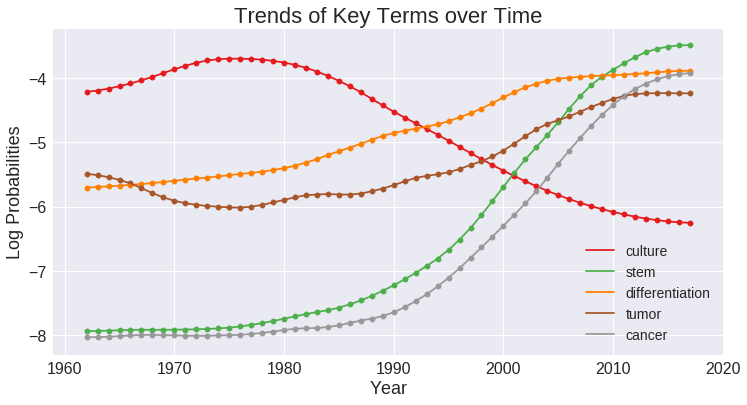

In [80]:
terms = ['culture', 'stem', 'differentiation', 'tumor', 'cancer']
plot_term_trends('08', jcb, word2id_path, output_prefix, terms, figsize=(12, 6))

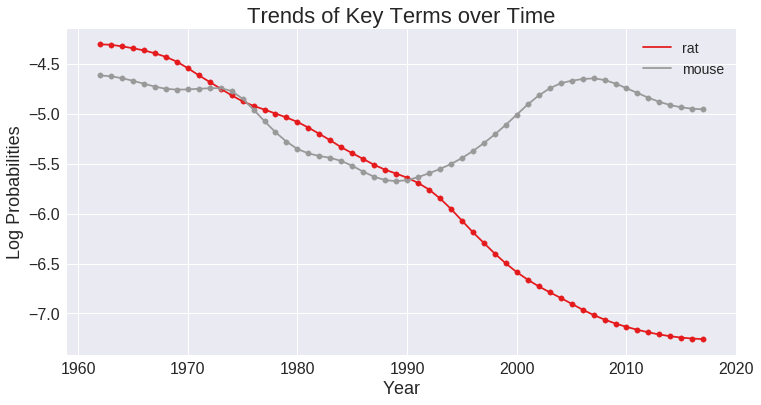

In [81]:
# model animal usage
terms = ['rat', 'mouse']
plot_term_trends('08', jcb, word2id_path, output_prefix, terms, figsize=(12, 6))

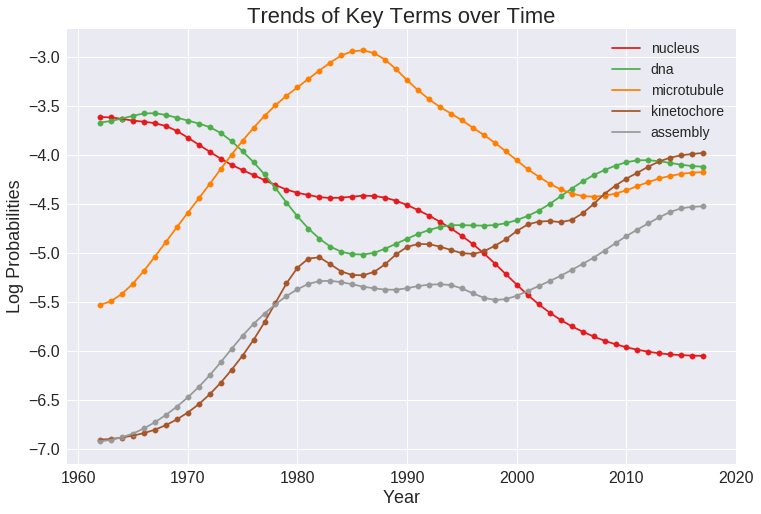

In [84]:
terms = ['nucleus', 
         'dna', 
         'microtubule', 
         'kinetochore', 
         'assembly']
plot_term_trends('02', jcb, word2id_path, output_prefix, terms, figsize=(12, 8))

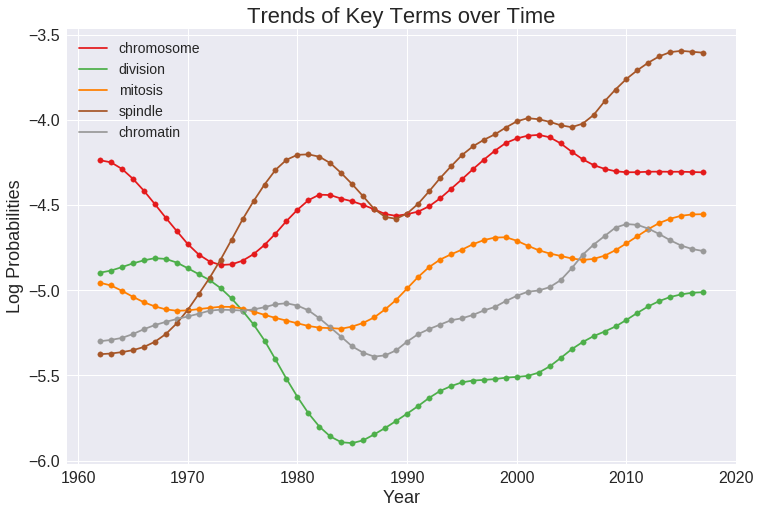

In [85]:
terms = ['chromosome', 
         'division', 
         'mitosis', 
         'spindle', 
         'chromatin']
plot_term_trends('02', jcb, word2id_path, output_prefix, terms, figsize=(12, 8))

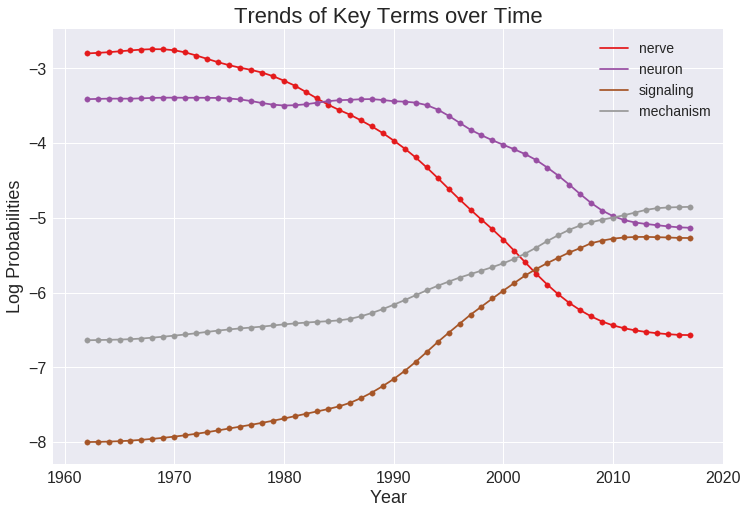

In [35]:
terms = ['nerve', 
         'neuron',
         'signaling', 
         'mechanism']
plot_term_trends('04', jcb, word2id_path, output_prefix, terms, figsize=(12, 8))